In [1]:
from __future__ import print_function
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import zscore
import seaborn as sns
import sys,os

### 1. Continous and binary responses in GDSC 
Distributions of logIC50 values classified as R or S 

### 2. Effects of different EGFRi compound on the same cell lines or samples
Do different EGFRi act similarly on the same cell line?

### 3.  Agreement between log(IC50) values in GDSC and CCLE
We correlate log(IC50) values for the same drug-cell line pair in CCLE and GDSC

In [2]:
nine_drugs = ['Docetaxel', 'Cisplatin', 'Erlotinib', 'Bortezomib','5-Fluorouracil',
         'Tamoxifen', 'Cetuximab', 'Paclitaxel', 'Gemcitabine']

EGFRi_drugs = ['Cetuximab', 'Panitumumab','Erlotinib','Pelitinib','Gefitinib','Lapatinib','Afatinib','ZD-6474']
root_dir = "/home/olya/SFU/Hossein/v2/"
tmp_dir = "/home/olya/SFU/Hossein/arrays/annotations/"

# 1. Continous and binary responses in GDSC 

* nine drugs 
* EGFRi

Conclustions: 

- top S values poorly separated from low R values
+ similar drugs demonstrate the same ditributions, e.g. see EGFRi drugs except cetuximab and chemo taxane drugds Docetaxel and Paclitaxel 

(Both plots show the same data in different representation)

In [11]:
drugs = list(set(nine_drugs+EGFRi_drugs))
dfs = []
for drug in drugs:
    try:
        df = pd.read_csv(root_dir+"/preprocessed/annotations/"+"GDSC_response."+drug+".tsv",sep = "\t")
        dfs.append(df)
    except:
        print(drug, "not found in GDSC",file = sys.stderr)
dfs = pd.concat(dfs)
dfs.loc[:,"logIC50"] = dfs["logIC50"].apply(np.float)
dfs.head()

ZD-6474 not found in GDSC
Pelitinib not found in GDSC
Panitumumab not found in GDSC


,sample_name,response,logIC50,drug
0,683665,R,2.807269,Cisplatin
1,683667,R,1.757559,Cisplatin
2,684057,S,1.131967,Cisplatin
3,684059,S,0.877124,Cisplatin
4,684062,S,1.342990,Cisplatin


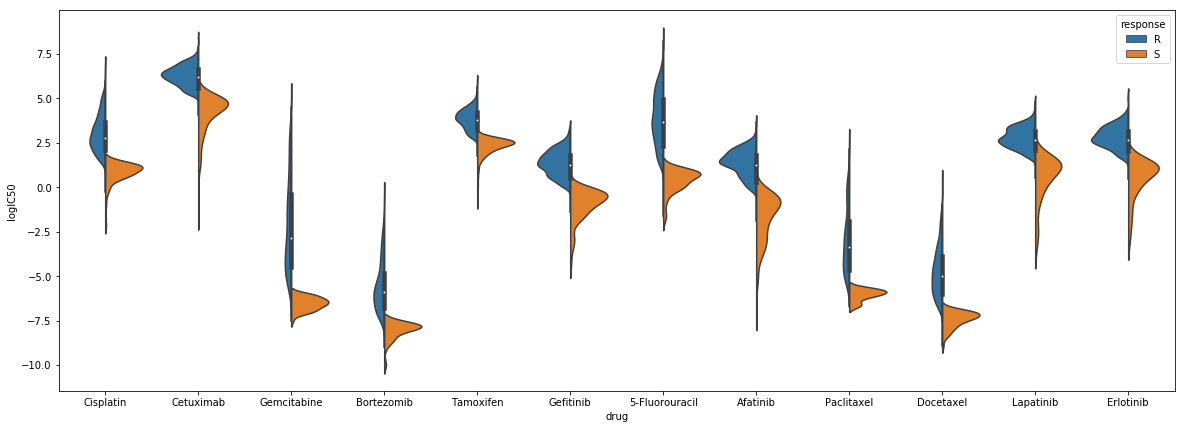

In [9]:
plt.figure(figsize=(20,7))
sns.violinplot(x="drug", y="logIC50", hue="response",data=dfs,split=True)

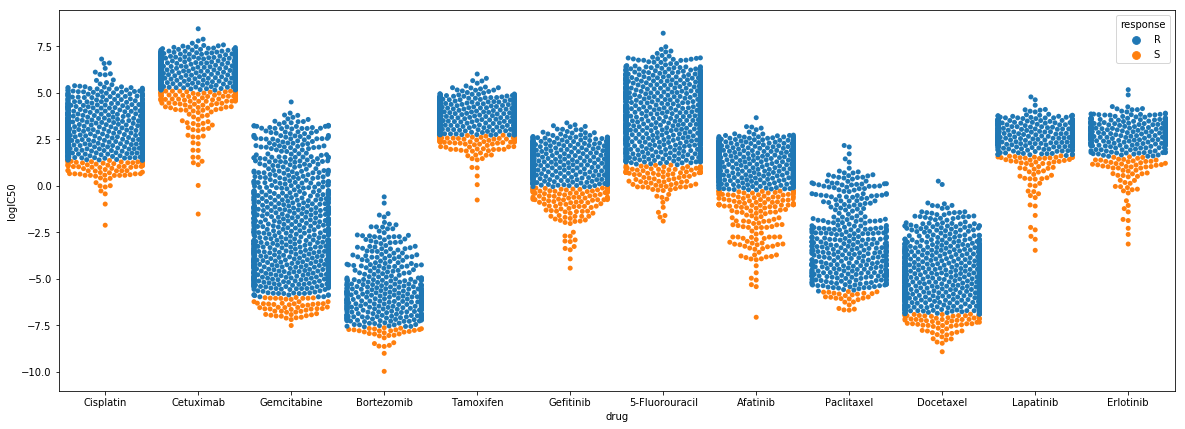

In [10]:
plt.figure(figsize=(20,7))
sns.swarmplot(x="drug", y="logIC50", hue="response",data=dfs)

# 2. Effects of different EGFRi compound on the same cell lines or samples

### For GDSC, PDX, TCGA
   * on each cohort independently
   * for every possible pair of drugs
       - find samples or cell lines treated by both
       - report how many samples in total, R/R, S/S R/S S/R S/S
       - test for independence of R and S labeles using two-tailed exact Fisher's test
   * TCGA not shown, because no patients treated by two drugs in TCGA 
    
### For CCLE and GDSC 
    * correlate IC50 or logIC50 values

In [50]:
from itertools import combinations
from scipy.stats import fisher_exact

## binary responses 

In [64]:
EGFRi_dict = {"GDSC":["Cetuximab", "Erlotinib", "Lapatinib", "Gefitinib", "Afatinib"],
"PDX":["Cetuximab","Erlotinib"]}

stats = {}
i = 0
for cohort in EGFRi_dict.keys():
    drugs = EGFRi_dict[cohort]
    for d1,d2 in combinations(drugs, r=2):
        res = {"cohort":cohort,"drug1":d1, "drug2":d2}
        r1 = pd.read_csv(root_dir + "response/"+cohort+"_response."+d1+".tsv",sep = "\t", index_col = 0)
        r2 = pd.read_csv(root_dir + "response/"+cohort+"_response."+d2+".tsv",sep = "\t", index_col = 0)
        shared_samples = set(r1.index.values).intersection(set(r2.index.values))
        # keep only shared samples 
        res["matching_samples"] = len(shared_samples)
        r1 = r1.loc[shared_samples,:]
        r2 = r2.loc[shared_samples,:]
        # drug  1 
        try:
            r1_r = set(r1.loc[r1["response"] == "R",:].index.values)
        except :
            print(r1.head())
        r1_s = set(r1.loc[r1["response"] == "S",:].index.values)
        res["drug1_S"] = len(r1_s)
        res["drug1_R"] = len(r1_r)
        # drug 2 
        r2_r = set(r2.loc[r2["response"] == "R",:].index.values)
        r2_s = set(r2.loc[r2["response"] == "S",:].index.values)
        res["drug2_S"] = len(r2_s)
        res["drug2_R"] = len(r2_r)
        # agreements 
        RR = r1_r.intersection(r2_r)
        RS =  r1_r.intersection(r2_s)
        SR = r1_s.intersection(r2_r)
        SS =  r1_s.intersection(r2_s)
        res["RR"] = len(RR)
        res["SS"] = len(SS)
        res["RS"] = len(RS)
        res["SR"] = len(SR)
        OR, p_val = fisher_exact([(len(RR),len(RS)), (len(SR),len(SS))])
        res["Exact Fisher's 2t p-val"] =  p_val
        stats[i] = res
        i+=1
stats = pd.DataFrame.from_dict(stats).T
stats = stats[["cohort", "drug1", "drug2","matching_samples","drug1_R","drug1_S","drug2_R","drug2_S", "RR","SS","RS","SR","Exact Fisher's 2t p-val"]]
stats

,cohort,drug1,drug2,matching_samples,drug1_R,drug1_S,drug2_R,drug2_S,RR,SS,RS,SR,Exact Fisher's 2t p-val
0,PDX,Cetuximab,Erlotinib,20,19,1,18,2,18,1,1,0,0.1
1,GDSC,Cetuximab,Erlotinib,330,307,23,270,60,259,12,48,11,0.000125597
2,GDSC,Cetuximab,Lapatinib,353,328,25,297,56,283,11,45,14,0.000473849
3,GDSC,Cetuximab,Gefitinib,758,659,99,654,104,602,47,57,52,2.68393e-19
4,GDSC,Cetuximab,Afatinib,761,662,99,625,136,578,52,84,47,1.06662e-17
5,GDSC,Erlotinib,Lapatinib,362,298,64,303,59,276,37,22,27,2.19329e-18
6,GDSC,Erlotinib,Gefitinib,328,271,57,300,28,258,15,13,42,4.63024e-06
7,GDSC,Erlotinib,Afatinib,330,273,57,299,31,262,20,11,37,4.97193e-10
8,GDSC,Lapatinib,Gefitinib,349,296,53,320,29,283,16,13,37,1.43534e-07
9,GDSC,Lapatinib,Afatinib,352,299,53,317,35,287,23,12,30,2.47162e-13


### CCLE IC50

CCLE Erlotinib Lapatinib matching samples 435 pearson r 0.557
CCLE Erlotinib ZD-6474 matching samples 427 pearson r 0.648
CCLE Lapatinib ZD-6474 matching samples 428 pearson r 0.371


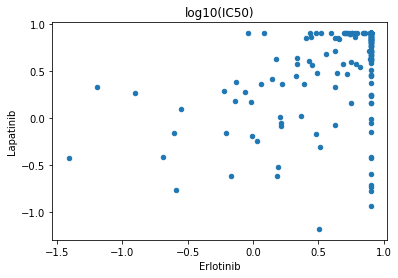

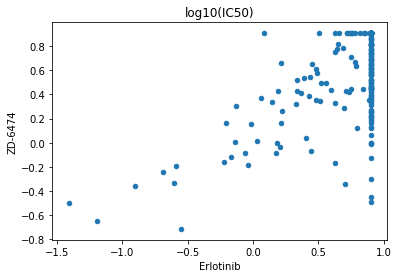

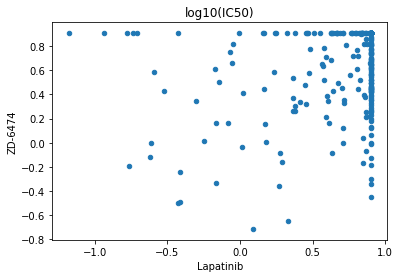

In [139]:
for d1,d2 in combinations(["Erlotinib", "Lapatinib", "ZD-6474"], r=2):
    r1 = pd.read_csv(root_dir + "response/"+"CCLE"+"_response."+d1+".tsv",sep = "\t", index_col = 0)
    r2 = pd.read_csv(root_dir + "response/"+"CCLE"+"_response."+d2+".tsv",sep = "\t", index_col = 0)
    shared_samples = set(r1.index.values).intersection(set(r2.index.values))
    ic50_1 = r1.loc[shared_samples,["IC50 (uM)"]]
    ic50_1["IC50 (uM)"] = ic50_1["IC50 (uM)"].apply(lambda x : np.log10(x))
    ic50_1.columns = [d1]
    ic50_2 = r2.loc[shared_samples,["IC50 (uM)"]]
    ic50_2["IC50 (uM)"] = ic50_2["IC50 (uM)"].apply(lambda x: np.log10(x))
    ic50_2.columns = [d2]
    df = pd.concat([ic50_2,ic50_1], axis =1)
    r = df.corr().iloc[0,1]
    df.plot(kind ="scatter", x = d1, y = d2, title="log10(IC50)")
    print("CCLE",d1, d2,"matching samples", len(shared_samples), "pearson r", round(df.corr().iloc[0,1],3))

## GDSC logIC50

GDSC Cetuximab Erlotinib matching samples 330 pearson r 0.352
GDSC Cetuximab Lapatinib matching samples 353 pearson r 0.264
GDSC Cetuximab Gefitinib matching samples 754 pearson r 0.447
GDSC Cetuximab Afatinib matching samples 757 pearson r 0.435
GDSC Erlotinib Lapatinib matching samples 362 pearson r 0.652
GDSC Erlotinib Gefitinib matching samples 328 pearson r 0.454
GDSC Erlotinib Afatinib matching samples 330 pearson r 0.467
GDSC Lapatinib Gefitinib matching samples 349 pearson r 0.42
GDSC Lapatinib Afatinib matching samples 352 pearson r 0.58
GDSC Gefitinib Afatinib matching samples 823 pearson r 0.725


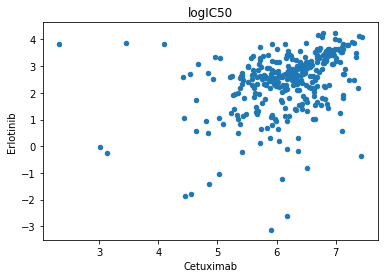

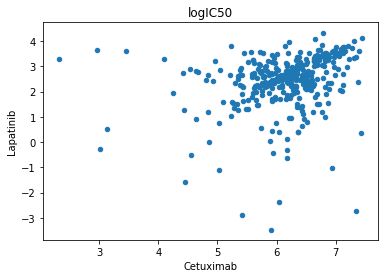

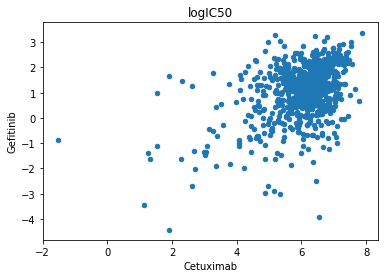

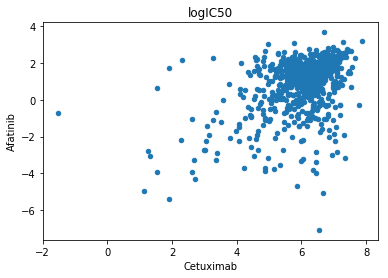

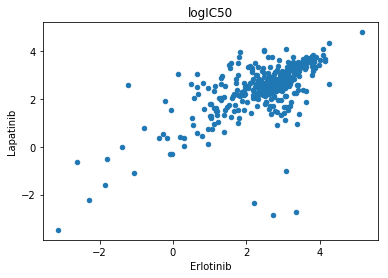

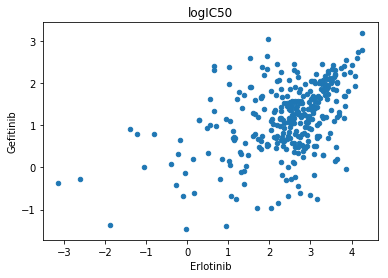

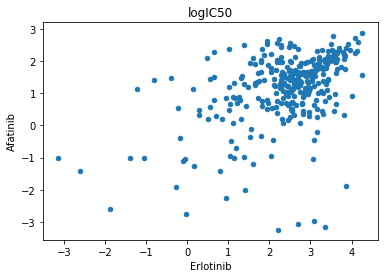

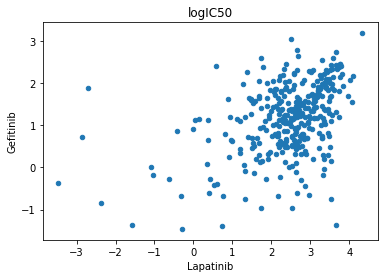

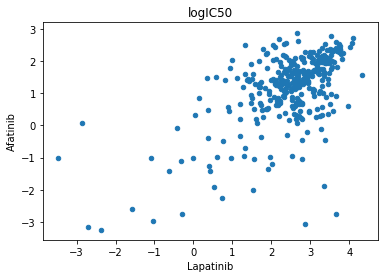

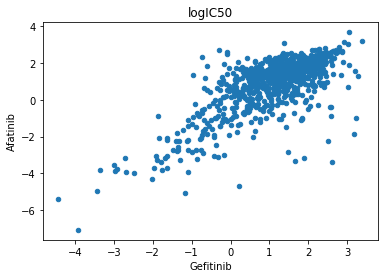

In [96]:

for d1,d2 in combinations(["Cetuximab", "Erlotinib", "Lapatinib", "Gefitinib", "Afatinib"], r=2):
    r1 = pd.read_csv(root_dir + "response/"+"GDSC"+"_response."+d1+".tsv",sep = "\t", index_col = 0)
    r2 = pd.read_csv(root_dir + "response/"+"GDSC"+"_response."+d2+".tsv",sep = "\t", index_col = 0)
    shared_samples = set(r1.index.values).intersection(set(r2.index.values))
    ic50_1 = r1.loc[shared_samples,["logIC50"]]
    ic50_1.columns = [d1]
    ic50_2 = r2.loc[shared_samples,["logIC50"]]
    ic50_2.columns = [d2]
    df = pd.concat([ic50_2,ic50_1], axis =1)
    r = df.corr().iloc[0,1]
    df.plot(kind ="scatter", x = d1, y = d2, title="logIC50")
    print("GDSC",d1, d2,"matching samples", len(shared_samples), "pearson r", round(df.corr().iloc[0,1],3))

# 3.  Agreement between log(IC50) values in GDSC and CCLE

* According to Haibe-Kains et al., "For drugs screened in both studies, only one had a Spearman correlation coefficient in measured response greater than 0.6."

* Although CCLE&GDSC paper sazs about 471 cell lines profiled in both studies, i found only 387.

* Let's compare IC50 values for "Erlotinib" and "Lapatinib" 
(results differ from Fig 2. in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4237165/figure/F11/)

In [159]:
celline_names = pd.read_excel("../../../GDSC/GDSC-CCLE-CTRP_conversion.xlsx","Cell lines")
celline_names = celline_names[["GDSC1000 cosmic id","CCLE name"]]
celline_names.dropna(inplace=True)
print("GDSC-CCLE pairs", celline_names.shape[0])
celline_names.head(5)

GDSC-CCLE pairs 387


,GDSC1000 cosmic id,CCLE name
0,906800,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
1,687452,5637_URINARY_TRACT
2,924100,22RV1_PROSTATE
4,687561,42MGBA_CENTRAL_NERVOUS_SYSTEM
5,906798,639V_URINARY_TRACT


In [160]:
GDSC2CCLE_cln = celline_names.set_index("GDSC1000 cosmic id").to_dict()["CCLE name"]

Erlotinib :	matching Cell Lines 86
Lapatinib :	matching Cell Lines 92


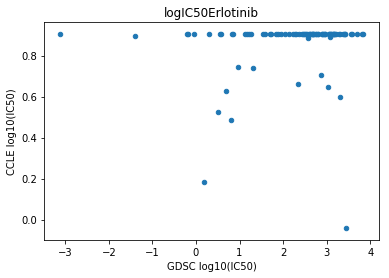

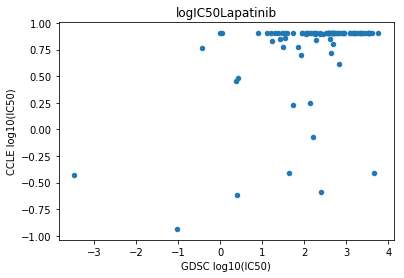

In [161]:
for drug in ["Erlotinib", "Lapatinib"]:
    # GDSC 
    r_gdsc = pd.read_csv(root_dir + "response/"+"GDSC"+"_response."+drug+".tsv",sep = "\t", index_col = 0)
    r_gdsc = r_gdsc.loc[set(GDSC2CCLE_cln.keys()).intersection(set(r_gdsc.index.values)),:]
    r_gdsc["CCLE_name"] = r_gdsc.index
    r_gdsc["CCLE_name"] = r_gdsc["CCLE_name"].apply(lambda x :GDSC2CCLE_cln[x] )
    r_gdsc["GDSC_name"] = r_gdsc.index.values
    r_gdsc.set_index("CCLE_name",inplace=True, drop = True)
    # CCLE 
    r_ccle = pd.read_csv(root_dir + "response/"+"CCLE"+"_response."+drug+".tsv",sep = "\t", index_col = 0)
    # common cell lines
    shared_cl = set(r_ccle.index.values).intersection(set(r_gdsc.index.values))
    r_gdsc = r_gdsc.loc[shared_cl,]
    r_gdsc.sort_index(inplace=True)
    r_ccle = r_ccle.loc[shared_cl,]
    r_ccle.sort_index(inplace=True)
    print(drug,":\tmatching Cell Lines", len(shared_cl))
    df = pd.concat([r_ccle, r_gdsc],axis = 1)[["IC50 (uM)","logIC50"]]
    df["IC50 (uM)"] = df["IC50 (uM)"].apply(lambda x: np.log10(x))
    df.columns = ["CCLE log10(IC50)","GDSC log10(IC50)"]
    df.plot(kind ="scatter", y = "CCLE log10(IC50)", x = "GDSC log10(IC50)", title="logIC50"+drug)